In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet201,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = DenseNet201(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 1, 1, 1920)

In [10]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [11]:
bnfeatures.shape

(3931, 1920)

In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [13]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-0

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.1min


[CV] .............. gamma=1e-06, C=0.01, score=0.505089, total= 1.7min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.505089, total= 1.7min
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total= 1.7min
[CV] gamma=0.001, C=0.01 .............................................
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.505089, total= 1.7min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505718, total= 1.7min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total= 1.7min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.505718, total= 1.7min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.3min


[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total= 1.9min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total= 1.9min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.656489, total= 1.9min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total= 1.9min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.664122, total= 1.9min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total= 1.9min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.505089, total= 1.9min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.4min


[CV] .............. gamma=0.001, C=0.01, score=0.860051, total= 1.3min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.869123, total= 1.3min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.877863, total= 1.3min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.885496, total= 1.3min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.895674, total= 1.3min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.820839, total= 1.8min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.853690, total= 1.8min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.6min


[CV] ................ gamma=0.1, C=0.01, score=0.505089, total= 1.8min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=10.0, C=0.01, score=0.505718, total= 1.8min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ................ gamma=0.1, C=0.01, score=0.505089, total= 1.8min
[CV] ................ gamma=1.0, C=0.01, score=0.505089, total= 1.8min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.505718, total= 1.8min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.505089, total= 1.8min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.505089, total= 1.8min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  8.7min


[CV] ............... gamma=10.0, C=0.01, score=0.505089, total= 1.8min
[CV] ............... gamma=10.0, C=0.01, score=0.505089, total= 1.8min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505718, total= 1.9min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total= 1.9min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total= 1.9min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total= 1.8min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total= 1.8min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  9.9min


[CV] ............... gamma=1e-06, C=0.1, score=0.505089, total= 1.8min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=0.001, C=0.1, score=0.927573, total=  40.5s
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-06, C=0.1, score=0.505089, total= 1.8min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.691233, total= 1.8min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.685751, total= 1.8min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.674300, total= 1.8min
[CV] gamma=10.0, C=0.1 ...............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.688295, total= 1.8min
[CV] gamma=10.0, C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 10.9min


[CV] ................ gamma=0.01, C=0.1, score=0.888183, total= 1.1min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................ gamma=0.01, C=0.1, score=0.898219, total= 1.1min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................ gamma=0.01, C=0.1, score=0.880407, total= 1.1min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................ gamma=0.01, C=0.1, score=0.919847, total= 1.1min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................ gamma=0.01, C=0.1, score=0.880407, total= 1.1min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.522901, total= 1.8min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.520966, total= 1.8min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 13.3min


[CV] ................ gamma=10.0, C=0.1, score=0.505089, total= 1.8min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ................ gamma=10.0, C=0.1, score=0.505089, total= 1.8min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ................ gamma=10.0, C=0.1, score=0.505089, total= 1.8min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505718, total= 1.8min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505089, total= 1.8min
[CV] gamma=0.001, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505089, total= 1.8min
[CV] gamma=0.001, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505089, total= 1.8min
[CV] gamma=0.001, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 15.0min


[CV] ............... gamma=1e-07, C=1.0, score=0.505089, total= 1.8min
[CV] gamma=0.1, C=1.0 ................................................
[CV] ............... gamma=1e-07, C=1.0, score=0.505089, total= 1.9min
[CV] gamma=0.1, C=1.0 ................................................
[CV] ............... gamma=1e-05, C=1.0, score=0.871501, total= 1.1min
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=1e-05, C=1.0, score=0.876747, total= 1.1min
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=0.001, C=1.0, score=0.950382, total=  26.3s
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=1e-07, C=1.0, score=0.505089, total= 1.9min
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=0.001, C=1.0, score=0.944020, total=  25.7s
[CV] gamma=1.0, C=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 16.5min


[CV] ................ gamma=0.01, C=1.0, score=0.968193, total=  58.9s
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=0.01, C=1.0, score=0.924936, total= 1.3min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.749682, total= 1.8min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.765903, total= 1.8min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.763359, total= 1.8min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.758270, total= 1.8min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.739186, total= 1.8min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 19.5min


[CV] .............. gamma=1e-05, C=10.0, score=0.942748, total=  38.2s
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.924936, total=  38.4s
[CV] gamma=0.001, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.540712, total= 1.8min
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.924936, total=  38.7s
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.505089, total= 1.8min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.505089, total= 1.8min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.505718, total= 1.8min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 20.3min


[CV] .............. gamma=0.001, C=10.0, score=0.977099, total=  25.0s
[CV] gamma=10.0, C=10.0 ..............................................
[CV] .............. gamma=0.001, C=10.0, score=0.959288, total=  24.0s
[CV] gamma=10.0, C=10.0 ..............................................
[CV] .............. gamma=0.001, C=10.0, score=0.979644, total=  25.0s
[CV] gamma=10.0, C=10.0 ..............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.902036, total= 1.1min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.898219, total= 1.1min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.875318, total= 1.1min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.692112, total= 1.8min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 23.5min


[CV] ............... gamma=10.0, C=10.0, score=0.532402, total= 1.8min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ................ gamma=1.0, C=10.0, score=0.595420, total= 1.8min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............... gamma=10.0, C=10.0, score=0.544529, total= 1.8min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............... gamma=10.0, C=10.0, score=0.535623, total= 1.8min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............... gamma=10.0, C=10.0, score=0.539440, total= 1.8min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............... gamma=10.0, C=10.0, score=0.543257, total= 1.8min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............. gamma=1e-08, C=100.0, score=0.687023, total= 1.8min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 24.2min


[CV] ............. gamma=1e-05, C=100.0, score=0.940204, total=  24.4s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=1e-05, C=100.0, score=0.968193, total=  26.4s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.942748, total=  39.8s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=0.001, C=100.0, score=0.972046, total=  24.8s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=0.001, C=100.0, score=0.972010, total=  25.4s
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.924936, total=  38.8s
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............. gamma=0.001, C=100.0, score=0.961832, total=  21.8s
[CV] gamma=10.0, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 27.2min


[CV] ............... gamma=0.1, C=100.0, score=0.781170, total= 1.8min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.923664, total=  37.4s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.763659, total= 1.8min
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.924936, total=  37.2s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=1.0, C=100.0, score=0.579416, total= 1.8min
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.781170, total= 1.8min
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.942748, total=  38.2s
[CV] gamma=0.0001, C=1000.0 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 29.7min remaining:  1.7min


[CV] .............. gamma=0.1, C=1000.0, score=0.763659, total= 1.5min
[CV] .............. gamma=0.1, C=1000.0, score=0.758270, total= 1.5min
[CV] .............. gamma=1.0, C=1000.0, score=0.591603, total= 1.5min
[CV] .............. gamma=1.0, C=1000.0, score=0.600509, total= 1.5min
[CV] ............. gamma=10.0, C=1000.0, score=0.535623, total= 1.4min
[CV] ............. gamma=10.0, C=1000.0, score=0.539440, total= 1.4min
[CV] .............. gamma=1.0, C=1000.0, score=0.591603, total= 1.7min
[CV] .............. gamma=0.1, C=1000.0, score=0.781170, total= 1.7min
[CV] .............. gamma=1.0, C=1000.0, score=0.579416, total= 1.7min
[CV] ............. gamma=10.0, C=1000.0, score=0.532402, total= 1.6min
[CV] .............. gamma=1.0, C=1000.0, score=0.595420, total= 1.7min
[CV] ............. gamma=10.0, C=1000.0, score=0.544529, total= 1.7min
[CV] .............. gamma=0.1, C=1000.0, score=0.772265, total= 1.8min
[CV] .............. gamma=0.1, C=1000.0, score=0.781170, total= 1.7min
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 30.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [14]:
top_model.cv_results_

{'mean_fit_time': array([85.62528901, 88.02775121, 83.12054019, 90.099055  , 89.60434346,
        62.8767695 , 87.48668551, 86.89331417, 87.2373898 , 87.22851791,
        89.11069231, 88.49367228, 87.53788505, 87.66541305, 52.84771609,
        32.98215513, 51.92956438, 86.61914463, 86.61173782, 87.13568931,
        88.02393575, 88.17072639, 87.47315221, 52.82716389, 30.8450882 ,
        21.27903314, 50.75034952, 86.93406434, 86.33169651, 86.347193  ,
        87.15056958, 86.97472706, 52.44339828, 30.67329049, 20.94841442,
        19.68213181, 68.79971852, 88.41578584, 87.07741084, 87.41744995,
        87.53708057, 52.26167355, 30.95005894, 20.65519767, 16.87759748,
        19.38946371, 68.61468029, 88.43739395, 87.93722773, 87.73338375,
        53.06573987, 30.48766003, 20.18286953, 16.96741385, 17.74463415,
        19.193609  , 62.90166626, 79.78990083, 77.60783286, 75.79961014]),
 'mean_score_time': array([21.58577242, 21.92533102, 21.51953688, 21.64408956, 21.47250824,
        15.85

In [15]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'gamma': 1e-08, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-07, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-06, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-05, 'C': 0.01},
 mean: 0.65454, std: 0.00690, params: {'gamma': 0.0001, 'C': 0.01},
 mean: 0.87764, std: 0.01240, params: {'gamma': 0.001, 'C': 0.01},
 mean: 0.82651, std: 0.01524, params: {'gamma': 0.01, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 0.1, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1.0, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 10.0, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-08, 'C': 0.1},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-07, 'C': 0.1},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-06, 'C': 0.1},
 mean: 0.68456, std: 0.00578, params: {'gamma': 1e-05, 'C': 0.1},
 mean: 0.88374, std: 0.01262, params: {'gamma': 0.0001, 'C': 0.1},
 mea

In [16]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'gamma': 0.001, 'C': 10.0} - score: 0.9700


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


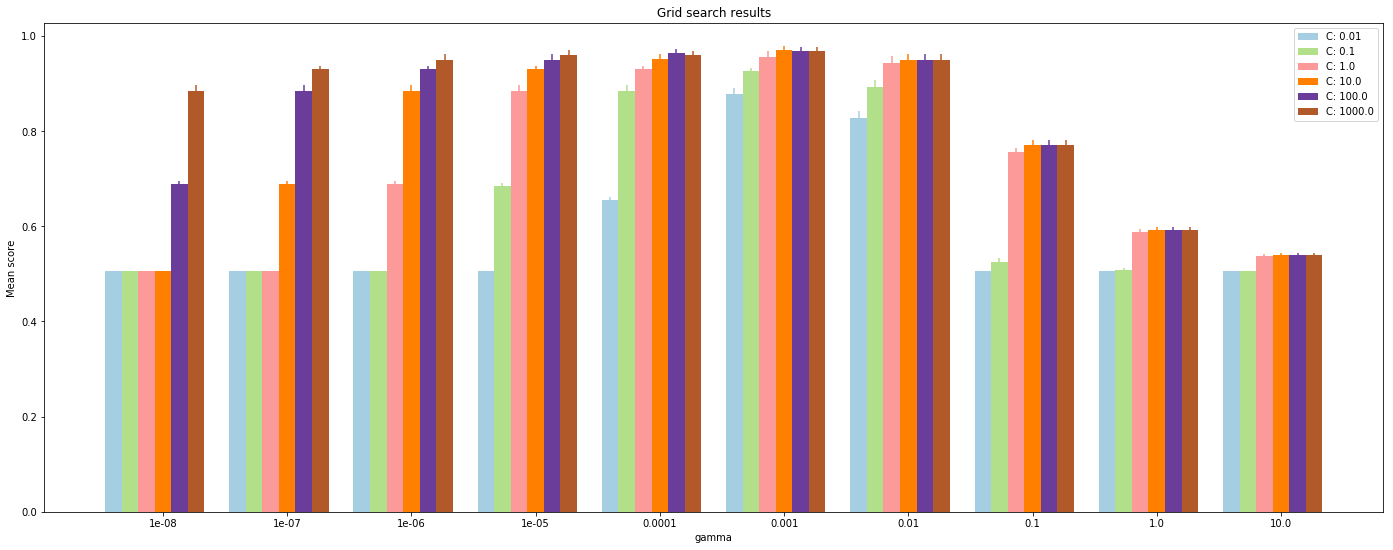

In [17]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()